In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mp
import pandas as pd
import numpy as np
import pysam
from Bio import SeqIO

# genome view plot

先从bed文件获取gene model数据

In [2]:
araport11_isoform_path = '/public/home/mowp/test/nanopore_cdna/supplementary_data/get_representative_gene_model/araport11.representative.gene_model.bed'
araport11_isoform = pd.read_csv(araport11_isoform_path, sep='\t', 
                                names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                       'score', 'strand', 'thickStart', 'thickEnd', 
                                       'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
                               )
araport11_isoform['gene_id'] = araport11_isoform['name'].map(lambda x: x.split('.')[0])
araport11_isoform = araport11_isoform.set_index('gene_id')

In [3]:
araport11_isoform

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
gene_id,,,,,,,,,,,,
AT1G01010,1,3630,5899,AT1G01010.1,0,+,3759,5630,0,6,"283,281,120,390,153,461,","0,365,855,1075,1543,1808,"
AT1G01020,1,6787,9130,AT1G01020.1,0,-,6914,8666,0,9,"282,76,67,86,74,46,90,48,560,","0,369,596,776,974,1154,1448,1629,1783,"
AT1G01030,1,11648,13714,AT1G01030.1,0,-,11863,12940,0,2,"1525,380,","0,1686,"
AT1G01040,1,23415,31120,AT1G01040.2,0,+,23518,31079,0,20,"1036,114,211,395,220,173,123,161,234,151,183,1...","0,1126,1336,1625,2108,2409,2665,2876,3127,3446..."
AT1G01046,1,28499,28706,AT1G01046.1,0,+,28634,28655,0,1,"21,","135,"
...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG09800,Mt,239951,240023,ATMG09800.1,0,-,239951,240023,0,1,"72,","0,"
ATMG09830,Mt,262130,262209,ATMG09830.1,0,-,262130,262209,0,1,"79,","0,"
ATMG09950,Mt,333650,333725,ATMG09950.1,0,-,333650,333725,0,1,"75,","0,"


In [4]:
araport11_isoform.loc['AT1G01046', 'chromStart']

28499

In [41]:
class IGV:
    def __init__(self, 
                 gene_id, 
                 fl_bam=None, 
                 non_fl_bam=None,
                 plot_polya = False):
        
        self.gene_id = gene_id
        self.fl_bam = fl_bam  # full length bam path
        self.non_fl_bam = non_fl_bam  # non full length bam path
        self.fl_bam_read = []  # a list consist of full length bam read
        self.non_fl_bam_read = []  # a list consist of non full length bam read
        self._get_gene_info()
        self.ypos = 1  # 画图的垂直位置
        self.xlim = [self.start, self.end]  # 画布水平边界
        self.plot_polya = plot_polya
        
    def _get_gene_info(self):
        '''
        Get gene info from bed file
        '''
        gene_info = araport11_isoform.loc[self.gene_id]  # araport11_isoform loaded from pandas
        self.chrom = gene_info.chrom
        self.start = gene_info.chromStart
        self.end = gene_info.chromEnd
        self.strand = gene_info.strand
        self.blockSizes = np.fromstring(gene_info.blockSizes, sep=',')
        self.blockStarts = np.fromstring(gene_info.blockStarts, sep=',') + self.start # 0 base
    
    def get_gene_id_from_tags(self, tags):
        for tag, value in tags:
            if tag == 'gi':
                return value
    
    def get_polya_from_tags(self, tags):
        for tag, value in tags:
            if tag == 'pa':
                return value

    def _setup(self, ax):
        '''
        设置边
        '''
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_major_locator(ticker.NullLocator())
    
    def plot_gene_model(self, ax, start, end, strand, blockSizes, blockStarts):
        '''
        Visualize gene model from bed file

        Parms:
            @ypos: yaxis of the gene in the plot [int]
            @start: start position of the gene [int]
            @end: end position of the gene [int]
            @strand: strand od the gene ['+' or '-']
            @blockSizes: size of exons [array]
            @blockStarts: start position of gene [array]

        example:
            @ypos: 1
            @start: 6787
            @end: 9130
            @strand: '-'
            @blockSizes: array([282.,  76.,  67.,  86.,  74.,  46.,  90.,  48., 560.]),
            @blockStarts: array([6787., 7156., 7383., 7563., 7761., 7941., 8235., 8416., 8570.]))
        '''
        small_relative = 0.02 * (end-start)  # 箭头突出部分相对长度
        ax.plot([start, end], [self.ypos, self.ypos], color='darkblue')  # 基因有多长这条线就有多长
        height = .25 # gene model 高度
        for exonstart, size in zip(blockStarts, blockSizes):
            if exonstart == start and strand == '-':  # 负链的最后一个exon
                vertices = [(start, self.ypos), 
                            (start+small_relative, self.ypos+height), (exonstart+size, self.ypos+height), 
                            (exonstart+size, self.ypos-height), (start+small_relative, self.ypos-height)]
                exon = mp.Polygon(vertices, closed=True, fill=True, color='darkblue')  # 多边形箭头 ⬅
            elif exonstart+size == end and strand == '+':  # 正链的最后一个exon
                vertices = [(exonstart, self.ypos-height), (exonstart, self.ypos+height), 
                            (end-small_relative, self.ypos+height), 
                            (end, self.ypos), (end-small_relative, self.ypos-height)]
                exon = mp.Polygon(vertices, closed=True, fill=True, color='darkblue')  # 多边形箭头 →
            else:  # 普通exon，无箭头
                exon = mp.Rectangle((exonstart, self.ypos-height), size, height*2, color='darkblue', linewidth=0)
            ax.add_patch(exon)
            
        self.ypos += -1  # 空行画下一部分
        
    def plot_bam_read(self, ax, read_list):
        read_color = 'skyblue'  # bam read color
        polya_color = 'lightcoral'
        for read in read_list:
            ax.plot([read.reference_start, read.reference_end], [self.ypos, self.ypos], color='grey', linewidth=0.5, alpha=.7)     
            for block_start, block_end in read.get_blocks():
                ax.plot([block_start, block_end], [self.ypos, self.ypos], color=read_color, linewidth=1)
            
            # 画polya尾巴
            if self.plot_polya:
                polya_len = self.get_polya_from_tags(read.get_tags())
                if self.strand == '+':
                    ax.plot([block_end, block_end+polya_len], [self.ypos, self.ypos], color=polya_color, linewidth=1)
                else:
                    block_start, _ = read.get_blocks()[0]
                    ax.plot([block_start-polya_len, block_start], [self.ypos, self.ypos], color=polya_color, linewidth=1)
                    
            self.ypos += -.1
    
    def bam_fetch(self, bam_file, read_list):
        '''
        预读入数据，将read数据导入read_list
        '''
        MIN_POLYA_LEN = 15
        with pysam.AlignmentFile(bam_file, 'rb') as bam:
            for read in bam.fetch(self.chrom, self.start, self.end):
                tags = read.get_tags()
                if self.get_gene_id_from_tags(tags) == self.gene_id:
                    polya_len = self.get_polya_from_tags(tags)  # 获取polya长度
                    if not self.plot_polya or polya_len >= MIN_POLYA_LEN:
                        read_list.append(read)
                        
                        '''
                        如果需要画polya，画布需要延伸位置画polya
                        不画则不用延伸
                        '''
                        left, right = 0, 0
                        if self.plot_polya:
                            if self.strand == '+':
                                right = polya_len
                            else:
                                left = polya_len 
                        
                        self.xlim[0] = min(self.xlim[0], read.reference_start-left)
                        self.xlim[1] = max(self.xlim[1], read.reference_end+right)
                    
            # 按照3'end排序
            if self.strand == '+':
                read_list.sort(key=lambda read: read.reference_end, reverse=True) 
            else:
                read_list.sort(key=lambda read: read.reference_start, reverse=False) 
                    
    def genomeview(self):
        '''
        可视化画图:
            先画gene model -> plot_gene_model
            再画bam文件 -> plot_bam_read
            如果是负链，则水平翻转，使所有基因为同一方向
        '''
        
        '''
        Fetching bam data!
        '''
        if self.fl_bam is not None:
            self.bam_fetch(self.fl_bam, self.fl_bam_read)
        if self.non_fl_bam is not None:
            self.bam_fetch(self.non_fl_bam, self.non_fl_bam_read)
        '''
        Start plotting!
        '''
        ysize = len(self.fl_bam_read) + len(self.non_fl_bam_read)
        annx = (self.start+self.end)/2
        fig, ax = plt.subplots(figsize=(6, 1+ysize*.05))
        # plot geng model
        ax.annotate(s=self.gene_id,
                    xy=(annx, self.ypos+.5), ha='center')
        self.plot_gene_model(ax, self.start, self.end, self.strand, self.blockSizes, self.blockStarts)
        
        # plot bam reads
        if self.fl_bam is not None:
            ax.annotate(s='full-length reads',
                        xy=(annx, self.ypos+.25), ha='center')
            self.plot_bam_read(ax, self.fl_bam_read)
            self.ypos += -.9  # 空行画下一部分
        if self.non_fl_bam is not None:
            ax.annotate(s='non-full-length reads',
                        xy=(annx, self.ypos+.25), ha='center')
            self.plot_bam_read(ax, self.non_fl_bam_read)
        
        '''
        Set axis!
        '''
        self._setup(ax)
        step = (self.end-self.start)//400*100  # 坐标轴步长
        
        if self.strand == '+':
            xticks = np.arange(self.start, self.xlim[1]+step, step)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xlim(self.xlim[0], self.xlim[1])
        else:
            # 如果为负链，将方向反过来
            xticks = np.arange(self.end, self.xlim[0]-step, -step)
            ax.set_xticks(xticks)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xlim(self.xlim[1], self.xlim[0])
        ax.set_xlabel('Length (nt)')

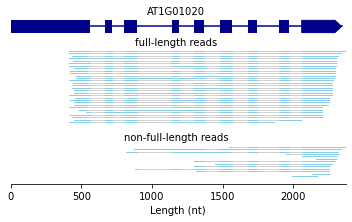

In [45]:
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT1G01020', pb_fl_read_path, pb_nonfl_read_path)
igv.genomeview()

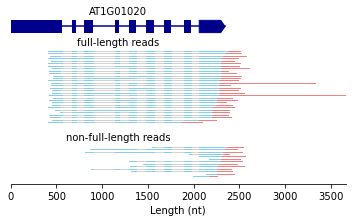

In [42]:
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT1G01020', pb_fl_read_path, pb_nonfl_read_path, plot_polya=True)
igv.genomeview()

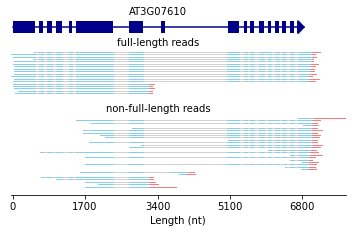

In [43]:
# IBM1
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT3G07610', pb_fl_read_path, pb_nonfl_read_path, plot_polya=True)
igv.genomeview()

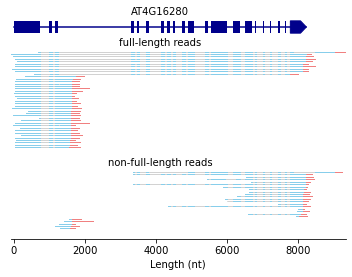

In [44]:
# FCA
pb_fl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.full_length.sorted.bam'
pb_nonfl_read_path = '/public/home/mowp/data/pacbio_cdna/full_length_transcripts/isoseq.non_full_length.sorted.bam'
igv = IGV('AT4G16280', pb_fl_read_path, pb_nonfl_read_path, plot_polya=True)
igv.genomeview()

In [178]:
class GeneModel():
    '''
    Plot gene model
    
    @Input:
        bed file
    @function:
        add_name: add the name which needs to be plotted
        clear: clean the name list, and reset the ax
        genomeview: show plot
    '''
    def __init__(self, isoform_path):
        self.bedfile = pd.read_csv(
            isoform_path, 
            sep='\t', 
            names=[
                'chrom', 'chromStart', 'chromEnd', 'name', 
                'score', 'strand', 'thickStart', 'thickEnd', 
                'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'
            ],
            index_col = 'name'
        )
        self.isoforms = []
        self.ypos = 1  # 画图的垂直位置
        self.start = None
        self.end = None
        self.strand = None

    def add_name(self, *isoforms):
        self.isoforms += list(isoforms)
        
    def clear(self):
        '''
        清楚isoform name数据，并初始化画布
        '''
        self.isoforms.clear()
        self.ypos = 1
        self.start = None
        self.end = None
        self.strand = None

    def _setup(self, ax):
        '''
        设置边
        '''
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_major_locator(ticker.NullLocator())

    def plot_gene_model(self, ax, start, end, strand, blockSizes, blockStarts):
        '''
        Visualize gene model from bed file

        Parms:
            @ypos: yaxis of the gene in the plot [int]
            @start: start position of the gene [int]
            @end: end position of the gene [int]
            @strand: strand od the gene ['+' or '-']
            @blockSizes: size of exons [array]
            @blockStarts: start position of gene [array]

        example:
            @ypos: 1
            @start: 6787
            @end: 9130
            @strand: '-'
            @blockSizes: array([282.,  76.,  67.,  86.,  74.,  46.,  90.,  48., 560.]),
            @blockStarts: array([6787., 7156., 7383., 7563., 7761., 7941., 8235., 8416., 8570.]))
        '''
        small_relative = 0.02 * (end-start)  # 箭头突出部分相对长度
        ax.plot([start, end], [self.ypos, self.ypos], color='darkblue')  # 基因有多长这条线就有多长
        height = .25 # gene model 高度
        for exonstart, size in zip(blockStarts, blockSizes):
            if exonstart == start and strand == '-':  # 负链的最后一个exon
                vertices = [(start, self.ypos), 
                            (start+small_relative, self.ypos+height), (exonstart+size, self.ypos+height), 
                            (exonstart+size, self.ypos-height), (start+small_relative, self.ypos-height)]
                exon = mp.Polygon(vertices, closed=True, fill=True, color='darkblue')  # 多边形箭头 ⬅
            elif exonstart+size == end and strand == '+':  # 正链的最后一个exon
                vertices = [(exonstart, self.ypos-height), (exonstart, self.ypos+height), 
                            (end-small_relative, self.ypos+height), 
                            (end, self.ypos), (end-small_relative, self.ypos-height)]
                exon = mp.Polygon(vertices, closed=True, fill=True, color='darkblue')  # 多边形箭头 →
            else:  # 普通exon，无箭头
                exon = mp.Rectangle((exonstart, self.ypos-height), size, height*2, color='darkblue', linewidth=0)
            ax.add_patch(exon)
            
        self.ypos += -1.5  # 空行画下一部分

    def genomeview(self):
        ysize = len(self.isoforms)*.8+.4
        fig, ax = plt.subplots(figsize=(6, ysize))

        for name in self.isoforms:
            isoform = self.bedfile.loc[name]
            start = isoform.chromStart
            end = isoform.chromEnd
            strand = isoform.strand
            blockSizes = np.fromstring(isoform.blockSizes, sep=',')
            blockStarts = np.fromstring(isoform.blockStarts, sep=',') + start # 0 base

            if self.start is None or self.start > start:
                self.start = start
            
            if self.end is None or self.end < end:
                self.end = end    

            if self.strand is None:
                self.strand = strand
            elif self.strand != strand:
                raise ValueError('Input isoforms are not the same strand!')
            
            if self.strand == '-':
                ax.annotate(s=name,
                            xy=(start, self.ypos+.4), ha='right')
            else:
                ax.annotate(s=name,
                            xy=(end, self.ypos+.4), ha='right')
            self.plot_gene_model(ax, start, end, strand, blockSizes, blockStarts)
        
        '''
        Set axis!
        '''
        self._setup(ax)
        step = (self.end-self.start)//400*100  # 坐标轴步长
        
        if self.strand == '+':
            xticks = np.arange(self.start, self.end+step, step)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xlim(self.start, self.end)
        else:
            # 如果为负链，将方向反过来
            xticks = np.arange(self.end, self.start-step, -step)
            ax.set_xticks(xticks)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xlim(self.end, self.start)
            
        ax.set_ylim(self.ypos, 2) 
        ax.set_xlabel('Length (nt)')

In [179]:
araport11_isoform_path = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11.all.bed'
genemodel = GeneModel(araport11_isoform_path)

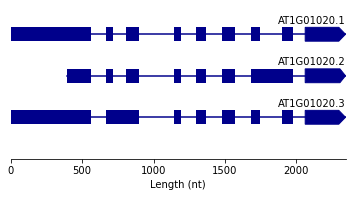

In [180]:
# 负链测试
genemodel.add_name('AT1G01020.1','AT1G01020.2', 'AT1G01020.3')
genemodel.genomeview()

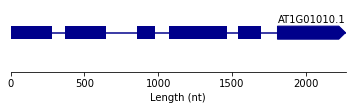

In [181]:
# 正链测试
genemodel.clear()
genemodel.add_name('AT1G01010.1')
genemodel.genomeview()